In [278]:
# Bibliotecas necessárias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [279]:
# Leitura dos dados

demandareal = pd.read_excel("./setembro2021.xlsx")
demandareal = demandareal["CONSUMO"].values
teste = np.reshape(demandareal,(30,24))

In [280]:
# Função objetivo a ser minimizada, com penalidade de demanda

def fitness(individuo, demanda, volume_maximo, volume_minimo, custo, vazao, check=0):
    volume = volume_maximo

    fit = np.sum(custo[individuo])
    volume_t = individuo * vazao - demanda
    volume_t = np.array([volume] + list(volume_t))
    volume_t = np.cumsum(volume_t)

    # Verifica as restrições de volume mínimo e máximo
    volume_penal = np.maximum(volume_t - volume_maximo, 0) + np.maximum(volume_minimo - volume_t, 0)

    if check == 1:
        print(volume_penal, fit, len(volume_penal))

    # Calcula a aptidão considerando as restrições
    fit += np.sum(volume_penal)
    return fit


In [281]:
# Definição da tarifa:

def S(t):
    hora = t % 24  # Calcula a hora do dia a partir do índice t
    if hora >= 17 and hora < 21:  # Horário de ponta
        return 1.63527
    else:  # Horário fora de ponta
        return 0.62124
        
tarifa = np.array([S(i) for i in range(len(demandareal))])

In [282]:
# Seleção

def selecao(populacao, aptidao):
    aid = np.random.choice(len(populacao), size=2, replace=False)
    bid = np.random.choice(len(populacao), size=2, replace=False)
    
    aid = aid[np.argmax(aptidao[aid])]
    bid = bid[np.argmax(aptidao[bid])]
    a = populacao[aid]
    b = populacao[bid]
    apt = aptidao[aid]
    bpt = aptidao[bid]
    
    return np.array([a, b]), np.array([apt, bpt])

In [283]:
# Cruzamento

"""def cruzamento(pais,aptidao,probcruz):
    if(np.random.rand()<probcruz):
        p = 1 - aptidao/(np.sum(aptidao))
        filho = np.array([pais[0][i] if(np.random.rand() < p[0]) else pais[1][i] for i in range(pais.shape[1])])
    else:
        filho = pais[np.argmin(aptidao),:]
    return filho"""

def cruzamento(pais, probcruz):
    if np.random.rand() < probcruz:
        filho = np.empty_like(pais[0])
        for i in range(len(filho)):
            if np.random.rand() < 0.5:
                filho[i] = pais[0][i]
            else:
                filho[i] = pais[1][i]
    else:
        filho = pais[np.random.randint(0, 2)]
    
    return filho


In [284]:
# Mutação

def mutacao(individuo, probmut):
    n = len(individuo)
    copia = np.copy(individuo)
    num_mutacoes = int(probmut * n)
    idx = np.random.choice(n, size=num_mutacoes, replace=False)

    for i in range(num_mutacoes):
        gene = idx[i]
        novo_valor = np.random.uniform(0, 1)
        novo_gene = 0 if novo_valor <= 0.5 else 1
        copia[gene] = novo_gene

    return copia



In [285]:
def AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals):
    
    np.random.seed(424)
    num_genes = len(demandareal)
    populacao = np.random.choice([True, False], size=(num_individuals, num_genes))
    F = lambda individuo: fitness(individuo, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
    aptidao = np.array([F(individuo) for individuo in populacao])

    historico = []
    contador = 0

    while True:
        
        pais,apt = selecao(populacao,aptidao)

        filho = cruzamento(pais,probcruz)
        filho = mutacao(filho,probmut)

        populacao[np.argmax(aptidao),:] = filho
        aptidao[np.argmax(aptidao)] = F(filho)

        historico.append([aptidao[np.argmin(aptidao)],np.mean(aptidao)])

        if(np.mean(aptidao) - aptidao[np.argmin(aptidao)] < 1e-5):
            break
        contador += 1
        if(contador%1000 == 0):
            print(aptidao[np.argmin(aptidao)])
        if(aptidao[np.argmin(aptidao)] < 6000):
            break
        
    historico = np.array(historico)
    return historico, populacao[np.argmin(aptidao)]

In [286]:
# Número de indivíduos na população inicial
volume_maximo = 5
volume_minimo = 2
vazao = 2

# Parâmetros genéticos:

probcruz = 0.7
probmut = 0.03
num_individuals = 50 #tamanho da população
#geracoes = 8000

# Algoritmo Genético:

dados,melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)

125777.66407000012
91645.91268000014
63525.0660300001
49693.80394000006
35309.268050000064
31078.140550000116
18840.701020000037
18156.83233999995
16057.586840000027
11586.770950000013
10170.166150000025
7450.524059999967
6165.192590000009


In [287]:
resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
print("Resultado do algoritmo genético:", resultado)

Resultado do algoritmo genético: 5270.807790000016


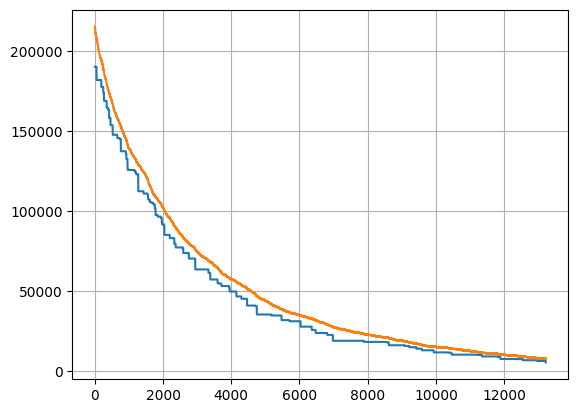

In [288]:
plt.plot(range(len(dados.T[0])),dados.T[0])
plt.plot(range(len(dados.T[0])),dados.T[1])
plt.grid()
plt.show()

In [289]:
#Resultado do algoritmo genético: 5700.467940000024 mut=0.1 e cruz=0.9,0.8,0.7,0.6 n =20 s
#RUIM

#Resultado do algoritmo genético: 5933.57499000005 mut=0.05 e cruz=0.9 n =20 22s
#Resultado do algoritmo genético: 5790.8070900000475 mut=0.05 e cruz=0.9 n =50 27s*
#Resultado do algoritmo genético: 5963.009019999947 mut=0.05 e cruz=0.9 n =100 49s

#Resultado do algoritmo genético: 5638.995690000059 mut=0.05 e cruz=0.8 n =20 20s
#Resultado do algoritmo genético: 5413.027940000003 mut=0.05 e cruz=0.8 n =50 32s
#Resultado do algoritmo genético: 5097.912119999964 mut=0.05 e cruz=0.8 n =100 53s*
#Resultado do algoritmo genético: 5700.467940000024 mut=0.05 e cruz=0.8 n =200 1m40s

#Resultado do algoritmo genético: 4778.611730000051 mut=0.05 e cruz=0.7 n =20 18s**
#Resultado do algoritmo genético: 5153.788249999951 mut=0.05 e cruz=0.7 n =50 31s
#Resultado do algoritmo genético: 5884.072900000009 mut=0.05 e cruz=0.7 n =100 1m1s
#Resultado do algoritmo genético: 5929.079410000002 mut=0.05 e cruz=0.7 n =200 1m54s

#Resultado do algoritmo genético: 5363.345459999939 mut=0.05 e cruz=0.6 n =20 17s*
#Resultado do algoritmo genético: 5847.991659999978 mut=0.05 e cruz=0.6 n =50 17s
#Resultado do algoritmo genético: 5564.453210000016 mut=0.05 e cruz=0.6 n =100 54s
#Resultado do algoritmo genético: 5904.708640000028 mut=0.05 e cruz=0.6 n =200 1m33s


#Resultado do algoritmo genético: 5323.528789999973 mut=0.03 e cruz=0.9 n =20 6s
#Resultado do algoritmo genético: 5712.854060000034 mut=0.03 e cruz=0.9 n =50 9s
#Resultado do algoritmo genético: 5741.098860000029 mut=0.03 e cruz=0.9 n =100 14s


#Resultado do algoritmo genético: 5483.028629999946 mut=0.03 e cruz=0.8 n =20 s
#Resultado do algoritmo genético: 5473.200340000062 mut=0.03 e cruz=0.8 n =50 s
#Resultado do algoritmo genético: 5754.9982399999835 mut=0.03 e cruz=0.8 n =100 s


#Resultado do algoritmo genético: 5666.693050000029 mut=0.03 e cruz=0.7 n =20 s

#Resultado do algoritmo genético: 5659.619560000021 mut=0.03 e cruz=0.6 n =20 s





In [290]:
# Parâmetros genéticos:

#probcruz = 0.6
#probmut = 0.05

num_individuals = 100 #tamanho da população

taxas_mutacao = [0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9]

resultados = []

for probmut in taxas_mutacao:
    for probcruz in taxas_cruzamento:
        dados, melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
        resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
        resultados.append((probmut, probcruz, resultado))

# Exibir os resultados
for resultado in resultados:
    probmut, probcruz, valor = resultado
    print(f"Taxa de Mutação: {probmut}, Taxa de Cruzamento: {probcruz}, Resultado: {valor}")


159472.52575000015
131564.28933000015
109832.72151000012
83616.53137000013
65734.83494000012
42860.101550000094
28786.79055000007
17744.88721999995
11706.281339999945
7329.76505999999
154843.31932000013
116206.90662000014
93595.50765000012
69100.28549000013
47705.468450000095
33078.280469999976
22374.289239999973
14615.913279999972
7660.86971999995
151114.51776000013
112972.77010000013
80644.59842000011
55957.3128500001
34772.46906000003
22441.90178999999
11657.264199999972
7077.6731999999465
152583.87645000013
106985.94469000012
74670.67022000013
43460.21597000008
27442.956520000072
16858.726059999954
10799.742659999987
6011.320419999984
159779.03475000014
134325.30738000013
100778.57252000012
80758.47518000011
62451.90549000011
40943.275960000065
29508.10637000003
20113.467299999982
14869.856920000026
10135.78056999996
6904.636159999945
155532.27326000013
121445.92864000011
92786.22563000012
69837.00587000012
47097.785120000095
34099.66404000006
20478.071800000027
12919.004289999952


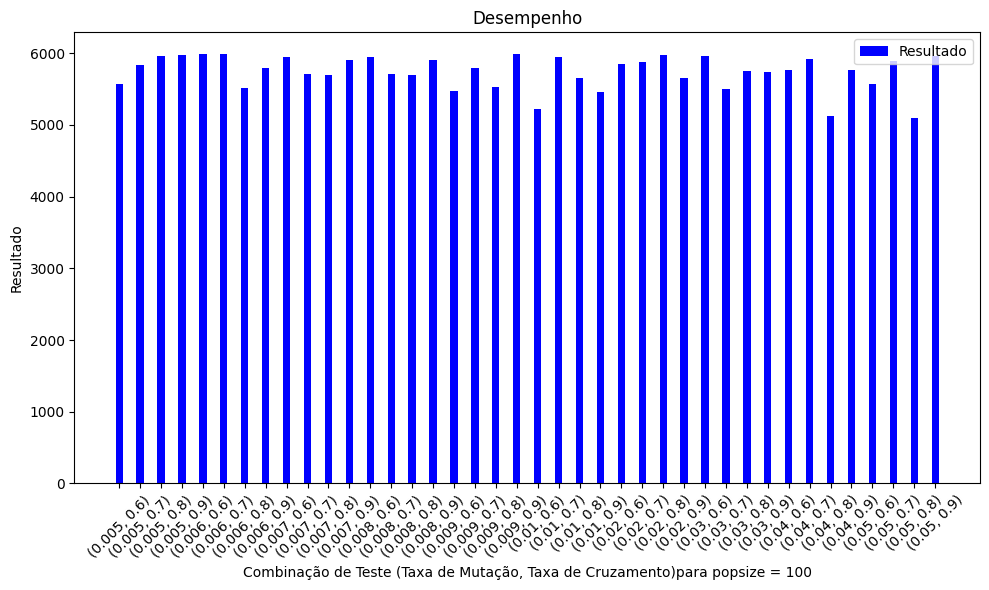

In [291]:
import numpy as np
import matplotlib.pyplot as plt

# Resultados fornecidos
resultados = [5573.554609999965, 5841.10196999995, 5957.8604100000175, 5968.418639999977, 5990.756389999984, 5984.458480000011, 5514.750190000008, 5798.572040000033, 5941.703369999978, 5710.836849999986, 5690.426699999961, 5908.942740000004, 5941.703369999978, 5710.836849999986, 5690.426699999961, 5908.942740000004, 5473.018479999982, 5796.8622799999675, 5527.987239999952, 5991.114759999967, 5228.469339999965, 5942.988169999971, 5659.163059999965, 5462.56003000002, 5843.0153000000055, 5876.308629999993, 5979.642670000003, 5653.330260000011, 5964.711039999992, 5495.653740000033, 5754.9982399999835, 5741.098860000029, 5766.598630000011, 5912.105609999952, 5129.984600000014, 5759.020180000026, 5564.453210000016, 5884.072900000009, 5097.912119999964, 5963.009019999947]

# Taxas de mutação e cruzamento correspondentes
taxas_mutacao = [0.005, 0.005, 0.005, 0.005, 0.006, 0.006, 0.006, 0.006, 0.007, 0.007, 0.007, 0.007, 0.008, 0.008, 0.008, 0.008, 0.009, 0.009, 0.009, 0.009, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.04, 0.04, 0.04, 0.04, 0.05, 0.05, 0.05, 0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9, 0.6, 0.7, 0.8, 0.9]

# Definição da legenda
legenda = ['Resultado']

# Aumento do tamanho da figura
fig, ax = plt.subplots(figsize=(10, 6))

# Configuração do gráfico
ind = np.arange(len(resultados))
width = 0.35
rects = ax.bar(ind, resultados, width, color='b', label=legenda[0])

# Configuração dos eixos
ax.set_xlabel('Combinação de Teste (Taxa de Mutação, Taxa de Cruzamento)para popsize = 100')
ax.set_ylabel('Resultado')
ax.set_title('Desempenho')

# Definindo rótulos do eixo x
rotulos = [f'({mutacao}, {cruzamento})' for mutacao, cruzamento in zip(taxas_mutacao, taxas_cruzamento)]
ax.set_xticks(ind)
ax.set_xticklabels(rotulos, rotation=45)

# Exibição da legenda
ax.legend(legenda)

# Exibição do gráfico
plt.tight_layout()
plt.show()


In [292]:
num_individuals = 150 #tamanho da população

taxas_mutacao = [0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9]

resultados = []

for probmut in taxas_mutacao:
    for probcruz in taxas_cruzamento:
        dados, melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
        resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
        resultados.append((probmut, probcruz, resultado))

# Exibir os resultados
for resultado in resultados:
    probmut, probcruz, valor = resultado
    print(f"Taxa de Mutação: {probmut}, Taxa de Cruzamento: {probcruz}, Resultado: {valor}")

170779.53574000014
146643.81234000012
119923.95670000011
98761.13911000013
85624.42927000012
71323.41796000012
54883.67022000011
41486.70116000009
29932.839540000066
22506.71294999996
15457.94830999995
12352.26621000005
7898.845299999945
6137.297390000006
163835.06281000012
144073.87250000014
123914.94267000012
99443.11911000013
84535.13516000014
65483.73114000012
48184.98084000007
38114.46791000009
27874.831169999998
16120.444899999962
11642.39466999994
8185.611339999971
6290.697080000016
162964.74217000013
140582.84242000015
112540.08499000013
87125.50788000012
71400.54602000014
50263.25037000009
38244.09139000009
25169.887130000065
17540.25426999997
12490.894589999942
8763.055919999957
158679.86040000012
132218.62600000013
103179.25934000014
81446.49827000011
58875.29571000009
37334.78868000009
23081.00666999995
16516.572419999993
12019.710239999955
8145.601650000016
167720.04070000013
144555.47567000013
129097.29925000011
103928.89461000012
80424.07005000014
72437.25858000013
60348

In [293]:
num_individuals = 200 #tamanho da população

taxas_mutacao = [0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05]
taxas_cruzamento = [0.6, 0.7, 0.8, 0.9]

resultados = []

for probmut in taxas_mutacao:
    for probcruz in taxas_cruzamento:
        dados, melhor_valor = AG(demandareal, tarifa, volume_maximo, volume_minimo, vazao, probcruz, probmut, num_individuals)
        resultado = fitness(melhor_valor, demandareal, volume_maximo, volume_minimo, tarifa, vazao)
        resultados.append((probmut, probcruz, resultado))

# Exibir os resultados
for resultado in resultados:
    probmut, probcruz, valor = resultado
    print(f"Taxa de Mutação: {probmut}, Taxa de Cruzamento: {probcruz}, Resultado: {valor}")

168874.31730000014
154159.09489000012
137349.41158000013
120513.02081000012
101529.25934000012
88433.67446000011
85174.53796000012
71937.47587000013
59661.49952000013
45853.717660000075
36871.00844000007
30020.492320000056
22401.271790000057
18742.113189999942
14705.071259999946
10399.411189999928
8213.915989999972
7049.197619999921
166552.87443000014
152758.67406000014
131956.69413000013
117350.77833000012
98618.23732000012
85275.27137000013
71242.03897000013
58319.23844000012
46989.42061000008
37266.270700000096
26885.55124999999
18538.85319000001
14099.529320000018
10881.25482999996
9278.90777999999
6750.270960000026
173532.73815000014
152584.94660000014
127296.81840000012
114363.86051000012
90050.31470000013
79697.40354000012
59307.95332000011
47784.723170000114
38592.74247000003
25506.897290000008
20739.22296000001
14811.896919999943
11890.740799999954
10056.514440000017
6200.9609599999685
170446.59388000015
136078.08490000013
130961.92460000011
109174.54554000012
90576.1829900001